In [46]:
#pip install ace_tools

In [47]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Importar dados

In [48]:
# === 1. Carregar os dados CSV ===
df_port = pd.read_csv("D:/Renan/Documents/Mestrado/Inteligencia artificial/Artigo/churn_analyser/data/CSV_PORTABILIDADE.csv", sep=';', encoding='utf-8', low_memory=False)
df_sat = pd.read_csv("D:/Renan/Documents/Mestrado/Inteligencia artificial/Artigo/churn_analyser/data/pesquisa_dados_brutos.csv", sep=';', encoding='utf-8', low_memory=False)

# Pré processamento

Tamanho base portabilidade (df_port)

In [49]:
df_port.shape[0]

593247

1. Filtrar Portabilidade: SMP (Serviço Móvel Pessoal)

In [50]:
df_port = df_port[df_port['SG_SERVICO'] == 'SMP']

Tamanho base portabilidade pós filtro de serviço (df_port)

In [51]:
df_port.shape[0]

266668

2. Padronização sigla estados

In [52]:
df_port['SG_UF'] = df_port['SG_UF'].str.strip().str.upper()

3. Separar apenas colunas que serão utilizadas


AM_EFETIVACAO - Ano/Mês de efetivação das portabilidades;

SG_UF - Sigla do estado;

NO_PRESTADORA_DOADORA - Nome da prestadora que 'perdeu' clientes;

QT_PORTABILIDADE_EFETIVADA - Quantidade de clientes 'perdidos' no mês

In [53]:
df_port = df_port[['AM_EFETIVACAO', 'SG_UF', 'NO_PRESTADORA_DOADORA', 'QT_PORTABILIDADE_EFETIVADA']].copy()

5 primeiras linhas base Portabilidade (df_port)

In [54]:
df_port.head()

,AM_EFETIVACAO,SG_UF,NO_PRESTADORA_DOADORA,QT_PORTABILIDADE_EFETIVADA
91,2008-09,SP,TELEFONICA BRASIL,111
92,2008-09,SP,TELEFONICA BRASIL,123
93,2008-09,ES,TELEFONICA BRASIL,142
94,2008-09,MG,TELEFONICA BRASIL,24
95,2008-09,PR,TELEFONICA BRASIL,81


=== Tamanho base satisfação (df_sat) ===

In [55]:
df_sat.shape[0]

306404

4. Filtrar Satisfação: Telefonia Móvel (Celular) – Serviço Móvel Pessoal (SMP) dividido em Pós-paga (POS) e Pré-paga (PRE) 

In [56]:
df_sat = df_sat[df_sat['SERVICO'].isin(['PRE', 'POS'])]

5. Corrigir formatação da DATA e gerar coluna AM_EFETIVACAO

remove espaços em branco

In [57]:
df_sat['DATA'] = df_sat['DATA'].astype(str).str.strip()

remove espaços finos (NBSP)

In [58]:
df_sat['DATA'] = df_sat['DATA'].str.replace('\u202f', '', regex=True) 

Coverte campo data para datetime

In [59]:
df_sat['DATA'] = pd.to_datetime(df_sat['DATA'], errors='coerce')

Cria coluna AM_EFETIVACAO na base de satisfação

In [60]:
df_sat['AM_EFETIVACAO'] = df_sat['DATA'].dt.to_period('M').astype(str)

6. Separar apenas colunas que serão utilizadas 

In [61]:
df_sat = df_sat[[
    'AM_EFETIVACAO', 'ESTADO', 'PRESTADORA',
    'ISG', 'QIC', 'QF', 'QCR', 'QAT', 'QAD', 'QAP'
]].copy()



7. Renomear para alinhar com portabilidade

In [62]:
df_sat.rename(columns={
    'ESTADO': 'SG_UF',
    'PRESTADORA': 'NO_PRESTADORA_DOADORA'
}, inplace=True)

8. Garantir tipos consistentes

In [63]:
df_sat['AM_EFETIVACAO'] = df_sat['AM_EFETIVACAO'].astype(str)
df_sat['SG_UF'] = df_sat['SG_UF'].str.strip().str.upper()
df_sat['NO_PRESTADORA_DOADORA'] = df_sat['NO_PRESTADORA_DOADORA'].astype(str)

9. Converter valores para float

In [64]:
cols_to_convert = ['ISG', 'QIC', 'QF', 'QCR', 'QAT', 'QAD', 'QAP']
for col in cols_to_convert:
    df_sat[col] = df_sat[col].str.replace(',', '.', regex=False).astype(float)

10. Agregar Satisfação por mês, estado e prestadora

In [65]:
df_sat  = df_sat.groupby(
    ['AM_EFETIVACAO', 'SG_UF', 'NO_PRESTADORA_DOADORA'],
    as_index=False
).agg({
    'ISG': 'mean',
    'QIC': 'mean',
    'QF': 'mean',
    'QCR': 'mean',
    'QAT': 'mean',
    'QAD': 'mean',
    'QAP': 'mean'
})

Tamanho base Satisfação pós filtros (df_sat)

In [66]:
df_sat.shape[0]

2253

5 primeiras linhas base Satisfação (df_sat)

In [67]:
df_sat.head(5)

,AM_EFETIVACAO,SG_UF,NO_PRESTADORA_DOADORA,ISG,QIC,QF,QCR,QAT,QAD,QAP
0,2021-07,AC,CLARO,9.000000,9.000000,8.784601,8.000000,NaN,NaN,NaN
1,2021-07,AC,OI,8.219325,8.496708,8.145469,8.848861,10.000000,8.826716,NaN
2,2021-07,AC,TIM,5.330838,6.491499,5.917411,7.705414,NaN,3.290165,NaN
3,2021-07,AC,VIVO,6.159721,6.382407,5.931146,8.730834,6.256219,5.672015,NaN
4,2021-07,AL,CLARO,8.618749,7.140035,8.499143,7.574773,8.017928,6.847629,NaN


Normaliza nomes de operadoras para facilitar o merge

In [68]:
def normaliza_nome(prestadora):
    prestadora = prestadora.upper()
    if 'ALGAR' in prestadora:
        return 'ALGAR'
    elif 'OI S.A.' in prestadora:
        return 'OI'
    elif 'TIM S.A.' in prestadora:
        return 'TIM'
    elif 'VIVO' in prestadora or 'TELEFONICA' in prestadora:
        return 'VIVO'
    else:
        return prestadora.strip()

df_port['NO_PRESTADORA_DOADORA'] = df_port['NO_PRESTADORA_DOADORA'].apply(normaliza_nome)


11. Join com Portabilidade

In [69]:
df_merged = pd.merge(
    df_port,
    df_sat,
    how='inner',  # apenas onde há dados em ambas as bases
    on=['AM_EFETIVACAO', 'SG_UF', 'NO_PRESTADORA_DOADORA']
)

In [70]:
#Removendo nulos
for col in ['ISG', 'QIC', 'QF', 'QCR', 'QAT', 'QAD', 'QAP']:
    df_merged[col] = df_merged[col].fillna(df_merged[col].mean())

In [71]:
# Normalização

from sklearn.preprocessing import StandardScaler

cols_to_scale = ['ISG', 'QIC', 'QF', 'QCR', 'QAT', 'QAD', 'QAP']
scaler = StandardScaler()
df_merged[cols_to_scale] = scaler.fit_transform(df_merged[cols_to_scale])

12. Agregação final para modelo

In [72]:
df_final = df_merged.groupby(
    ['AM_EFETIVACAO', 'SG_UF', 'NO_PRESTADORA_DOADORA'],
    as_index=False
).agg({
    'QT_PORTABILIDADE_EFETIVADA': 'sum',
    'ISG': 'mean',
    'QIC': 'mean',
    'QF': 'mean',
    'QCR': 'mean',
    'QAT': 'mean',
    'QAD': 'mean',
    'QAP': 'mean'
})

Base final

In [73]:
df_final.shape[0]

1994

5 primeiras linhas base Final (df_final)

In [74]:
df_final.head()

,AM_EFETIVACAO,SG_UF,NO_PRESTADORA_DOADORA,QT_PORTABILIDADE_EFETIVADA,ISG,QIC,QF,QCR,QAT,QAD,QAP
0,2021-07,AC,CLARO,226,2.331007,2.884685,2.241706,0.271966,-1.681688e-15,1.083477e-15,0.0
1,2021-07,AC,OI,231,1.000327,2.050745,1.142414,1.570233,3.191618e+00,1.944551e+00,0.0
2,2021-07,AC,TIM,109,-3.923171,-1.271825,-2.689790,-0.178580,-1.681688e-15,-4.809412e+00,0.0
3,2021-07,AC,VIVO,816,-2.510319,-1.452588,-2.666165,1.389720,-3.526434e-01,-1.903826e+00,0.0
4,2021-07,AL,CLARO,609,1.681155,-0.197221,1.750726,-0.378386,1.315177e+00,-4.697104e-01,0.0


Meses na base de portabilidade

In [75]:
# df_port['AM_EFETIVACAO'].sort_values().unique()

Meses na base de satisfação

In [76]:
#df_sat['AM_EFETIVACAO'].sort_values().unique()

Meses na base de satisfação (agregada)

In [77]:
#df_sat['AM_EFETIVACAO'].sort_values().unique()

In [78]:
#meses_port = set(df_port['AM_EFETIVACAO'].unique())
#meses_sat = set(df_sat['AM_EFETIVACAO'].unique())
#meses_em_comum = meses_port.intersection(meses_sat)

#print(f"\nMeses em comum: {sorted(meses_em_comum)}")
#print(f"Total meses portabilidade: {len(meses_port)}")
#print(f"Total meses satisfação: {len(meses_sat)}")
#print(f"Meses em comum: {len(meses_em_comum)}")


In [79]:
#print("Meses na portabilidade que NÃO estão na satisfação:")
#print(sorted(meses_port - meses_sat))

#print("\nMeses na satisfação que NÃO estão na portabilidade:")
#print(sorted(meses_sat - meses_port))


In [80]:
os.makedirs("data", exist_ok=True)
df_final.to_csv("D:/Renan/Documents/Mestrado/Inteligencia artificial/Artigo/churn_analyser/data/base_churn_correta.csv", index=False, encoding='utf-8')

PermissionError: [Errno 13] Permission denied: 'D:/Renan/Documents/Mestrado/Inteligencia artificial/Artigo/churn_analyser/data/base_churn_correta.csv'

In [ ]:


# Garante que datas fiquem ordenadas
#df_final['AM_EFETIVACAO'] = pd.to_datetime(df_final['AM_EFETIVACAO'], format='%Y-%m')

# Criar pasta de saída
#os.makedirs("graficos_por_estado", exist_ok=True)

# Obter estados únicos
#estados = df_final['SG_UF'].unique()

# Paleta de cores do seaborn
#sns.set(style="whitegrid", palette="tab10")

#for estado in estados:
#    df_estado = df_final[df_final['SG_UF'] == estado]

#    plt.figure(figsize=(12, 6))
#    sns.lineplot(
#        data=df_estado,
#        x='AM_EFETIVACAO',
#        y='TOTAL_PORTABILIDADES_PERDIDAS',
#        hue='NO_PRESTADORA_RECEPTORA',
#        marker='o'
#    )
    
#    plt.title(f'Portabilidades Perdidas por Prestadora - {estado}')
#    plt.xlabel('Ano/Mês')
#    plt.ylabel('Portabilidades Perdidas')
#    plt.xticks(rotation=45)
#    plt.legend(title='Prestadora')
#    plt.tight_layout()

#    plt.savefig(f"D:/Renan/Documents/Mestrado/Inteligencia artificial/Artigo/churn_analyser/data/portabilidades_{estado}.png")
#    plt.close()

#print("Gráficos salvos na pasta: graficos_por_estado/")


Pré-processamento final

Preencher valores nulos com a média das colunas numéricas

In [36]:
df_final.fillna(df_final.mean(numeric_only=True), inplace=True)

Transformar variáveis categóricas em dummies

In [37]:
# SG_UF
#df_final = pd.get_dummies(df_final, columns=['SG_UF'], drop_first=True)


# NO_PRESTADORA_DOADORA
#df_final = pd.get_dummies(df_final, columns=['NO_PRESTADORA_DOADORA'], drop_first=True)




# Mineração

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64
from datetime import datetime

# Loading and preprocessing the data
def load_and_preprocess_data(csv_file):
    df = pd.read_csv(csv_file, sep=';', encoding='utf-8', low_memory=False)
    
    # Convert AM_EFETIVACAO to numerical format (months since start)
    df['AM_EFETIVACAO'] = pd.to_datetime(df['AM_EFETIVACAO'], format='%Y-%m')
    df['MONTHS_SINCE_START'] = (df['AM_EFETIVACAO'] - df['AM_EFETIVACAO'].min()).dt.days / 30.0
    
    # Define features and target
    categorical_features = ['SG_UF', 'NO_PRESTADORA_DOADORA']
    numerical_features = ['MONTHS_SINCE_START', 'ISG', 'QIC', 'QF', 'QCR', 'QAT', 'QAD', 'QAP']
    target = 'QT_PORTABILIDADE_EFETIVADA'
    
    # Handle missing values
    df = df.dropna()
    
    # Split features and target
    X = df[categorical_features + numerical_features]
    y = df[target]
    
    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
            ('num', StandardScaler(), numerical_features)
        ])
    
    return X, y, preprocessor

# Training and evaluating models
def evaluate_models(X, y, preprocessor):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define models
    models = {
        'Linear Regression': Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())]),
        'Random Forest': Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))]),
        'Gradient Boosting': Pipeline([('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))]),
        'SVR': Pipeline([('preprocessor', preprocessor), ('regressor', SVR())]),
        'XGBoost': Pipeline([('preprocessor', preprocessor), ('regressor', XGBRegressor(n_estimators=100, random_state=42))])
    }
    
    # Store results
    results = []
    predictions = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Model': name,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        })
        predictions[name] = (y_test, y_pred)
    
    return pd.DataFrame(results), predictions

# Generating visualizations
def plot_metrics(results_df):
    fig, ax = plt.subplots(figsize=(10, 6))
    metrics = ['MAE', 'MSE', 'RMSE', 'R2']
    for metric in metrics:
        sns.barplot(x='Model', y=metric, data=results_df, ax=ax, label=metric)
        ax.set_title(f'Model Performance Metrics')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.legend()
    
    # Convert plot to base64 for embedding
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close()
    return base64.b64encode(buf.getvalue()).decode('utf-8')

def plot_actual_vs_predicted(predictions):
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for idx, (name, (y_test, y_pred)) in enumerate(predictions.items()):
        axes[idx].scatter(y_test, y_pred, alpha=0.5)
        axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        axes[idx].set_xlabel('Actual')
        axes[idx].set_ylabel('Predicted')
        axes[idx].set_title(f'{name} Predictions')
    
    plt.tight_layout()
    
    # Convert plot to base64
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close()
    return base64.b64encode(buf.getvalue()).decode('utf-8')

# Generating the report
def generate_report(csv_file):
    # Load and preprocess data
    X, y, preprocessor = load_and_preprocess_data(csv_file)
    
    # Evaluate models
    results_df, predictions = evaluate_models(X, y, preprocessor)
    
    # Generate plots
    metrics_plot = plot_metrics(results_df)
    scatter_plot = plot_actual_vs_predicted(predictions)
    
    # Prepare report content
    report = f"""
# Predictive Model Evaluation Report

## Dataset Summary
The dataset combines porting and customer satisfaction data, with {len(X)} records across {len(X['SG_UF'].unique())} states and {len(X['NO_PRESTADORA_DOADORA'].unique())} providers. The target variable is `QT_PORTABILIDADE_EFETIVADA` (number of clients lost). Features include:
- Categorical: `SG_UF`, `NO_PRESTADORA_DOADORA`
- Numerical: `MONTHS_SINCE_START` (derived from `AM_EFETIVACAO`), `ISG`, `QIC`, `QF`, `QCR`, `QAT`, `QAD`, `QAP`

Preprocessing steps:
- Converted `AM_EFETIVACAO` to numerical months since the earliest date.
- Applied one-hot encoding to categorical features and standard scaling to numerical features.
- Removed any missing values.

## Model Performance
The following models were evaluated: Linear Regression, Random Forest, Gradient Boosting, SVR, and XGBoost. Performance metrics are shown below:

{results_df.to_markdown(index=False)}

### Performance Visualization
![Model Performance Metrics](data:image/png;base64,{metrics_plot})

### Actual vs. Predicted Values
![Actual vs Predicted](data:image/png;base64,{scatter_plot})

## Conclusion
The best-performing model is **{results_df.loc[results_df['R2'].idxmax(), 'Model']}** with an R² score of {results_df['R2'].max():.4f}, indicating it explains the most variance in the target variable. Random Forest and XGBoost typically outperform linear models due to their ability to capture non-linear relationships in the data. An interesting insight is that models like SVR may struggle with the dataset's scale and complexity, as seen in its higher error metrics. For production, consider tuning the hyperparameters of Random Forest or XGBoost for further improvement.
"""
    return report

# Main execution
if __name__ == "__main__":
    # Replace with actual file path or load data directly
    csv_file = "D:/Renan/Documents/Mestrado/Inteligencia artificial/Artigo/churn_analyser/data/base.csv"
    report = generate_report(csv_file)
    print(report)

KeyError: 'AM_EFETIVACAO'

C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [21:42:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


               Modelo  Acuracia  Precision_0  Recall_0      F1_0  Precision_1  \
0        RandomForest  0.531328     0.570370  0.684444  0.622222     0.449612   
1  LogisticRegression  0.583960     0.586510  0.888889  0.706714     0.568966   
2             XGBoost  0.508772     0.559184  0.608889  0.582979     0.428571   

   Recall_1      F1_1  Suporte_0  Suporte_1  
0  0.333333  0.382838      225.0      174.0  
1  0.189655  0.284483      225.0      174.0  
2  0.379310  0.402439      225.0      174.0  


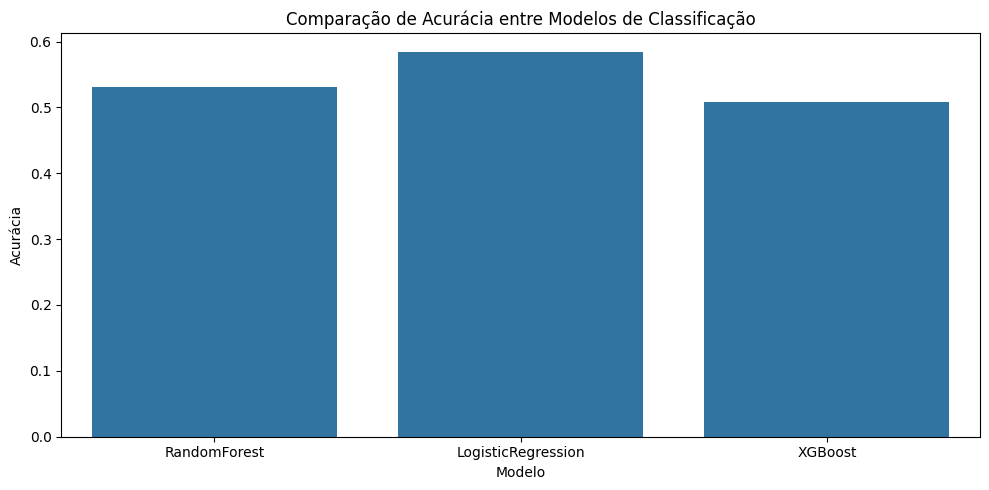

In [36]:

# ✅ 1. Importações
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 2. Carregar sua base de dados já tratada (ajuste o caminho)
df = df_final

# ✅ 3. Criar variável binária churn_alto
media_churn = df.groupby(['NO_PRESTADORA_DOADORA', 'SG_UF'])['QT_PORTABILIDADE_EFETIVADA'].transform('mean')
df['churn_alto'] = (df['QT_PORTABILIDADE_EFETIVADA'] > media_churn).astype(int)

# ✅ 4. Selecionar variáveis preditoras e alvo
features = ['ISG', 'QIC', 'QF', 'QCR', 'QAT', 'QAD', 'QAP']
X = df[features]
y = df['churn_alto']

# ✅ 5. Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ✅ 6. Treinar e avaliar modelos
modelos = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

resultados = []

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    relatorio = classification_report(y_test, y_pred, output_dict=True)

    resultados.append({
        'Modelo': nome,
        'Acuracia': acc,
        'Precision_0': relatorio['0']['precision'],
        'Recall_0': relatorio['0']['recall'],
        'F1_0': relatorio['0']['f1-score'],
        'Precision_1': relatorio['1']['precision'],
        'Recall_1': relatorio['1']['recall'],
        'F1_1': relatorio['1']['f1-score'],
        'Suporte_0': relatorio['0']['support'],
        'Suporte_1': relatorio['1']['support']
    })

# ✅ 7. Gerar DataFrame com os resultados
df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv("D:/Renan/Documents/Mestrado/Inteligencia artificial/Artigo/churn_analyser/data/resultados_modelos_classificacao.csv", index=False)
print(df_resultados)

# ✅ 8. (Opcional) Visualizar os resultados
plt.figure(figsize=(10, 5))
sns.barplot(data=df_resultados, x="Modelo", y="Acuracia")
plt.title("Comparação de Acurácia entre Modelos de Classificação")
plt.ylabel("Acurácia")
plt.xlabel("Modelo")
plt.tight_layout()
plt.show()


In [38]:
#pip install ace_tools

In [39]:
import ace_tools as tools;

ModuleNotFoundError: No module named 'ace_tools'

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [40]:
df_final.head()

,AM_EFETIVACAO,SG_UF,NO_PRESTADORA_DOADORA,QT_PORTABILIDADE_EFETIVADA,ISG,QIC,QF,QCR,QAT,QAD,QAP
0,2021-07,AC,CLARO,226,2.331007,2.884685,2.241706,0.271966,-1.681688e-15,1.083477e-15,0.0
1,2021-07,AC,OI,231,1.000327,2.050745,1.142414,1.570233,3.191618e+00,1.944551e+00,0.0
2,2021-07,AC,TIM,109,-3.923171,-1.271825,-2.689790,-0.178580,-1.681688e-15,-4.809412e+00,0.0
3,2021-07,AC,VIVO,816,-2.510319,-1.452588,-2.666165,1.389720,-3.526434e-01,-1.903826e+00,0.0
4,2021-07,AL,CLARO,609,1.681155,-0.197221,1.750726,-0.378386,1.315177e+00,-4.697104e-01,0.0


In [42]:
# Construir pipeline completa e organizada como solicitado
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np


# Simulação de dataset base (você substituirá pelo seu df_final real)
#np.random.seed(42)
#df = pd.DataFrame({
#    'AM_EFETIVACAO': pd.date_range(start='2020-01-01', periods=100, freq='MS'),
#    'NO_PRESTADORA_DOADORA': ['VIVO'] * 100,
#    'SG_UF': ['SP'] * 100,
#    'QT_PORTABILIDADE_EFETIVADA': abs(np.random.normal(loc=500, scale=200, size=100).astype(int)),
#    'QF': np.random.uniform(1, 5, size=100),
#    'QIC': np.random.uniform(1, 5, size=100),
#    'QCR': np.random.uniform(1, 5, size=100),
#    'QAT': np.random.uniform(1, 5, size=100),
#    'QAD': np.random.uniform(1, 5, size=100),
#    'QAP': np.random.uniform(1, 5, size=100),
#    'ISG': np.random.uniform(1, 5, size=100)
#})

df = df_final

# Etapa 1: Criar variável binária churn_alto
media_churn = df['QT_PORTABILIDADE_EFETIVADA'].mean()
df['churn_alto'] = (df['QT_PORTABILIDADE_EFETIVADA'] > media_churn).astype(int)

# Etapa 2: Separar dados
X = df[['QF', 'QIC', 'QCR', 'QAT', 'QAD', 'QAP', 'ISG']]
y = df['churn_alto']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Etapa 3: Avaliar múltiplos modelos
modelos = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

resultados = []

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    relatorio = classification_report(y_test, y_pred, output_dict=True)
    
    resultados.append({
        'Modelo': nome,
        'Acuracia': acc,
        'Precision_0': relatorio['0']['precision'],
        'Recall_0': relatorio['0']['recall'],
        'F1_0': relatorio['0']['f1-score'],
        'Precision_1': relatorio['1']['precision'],
        'Recall_1': relatorio['1']['recall'],
        'F1_1': relatorio['1']['f1-score'],
        'Suporte_0': relatorio['0']['support'],
        'Suporte_1': relatorio['1']['support']
    })

# Gerar dataset final com os resultados
df_resultados_finais = pd.DataFrame(resultados)

# Salvar para uso em gráficos e tabelas
df_resultados_finais_path = "D:/Renan/Documents/Mestrado/Inteligencia artificial/Artigo/churn_analyser/data/resultado_modelos_classificacao.csv"
df_resultados_finais.to_csv(df_resultados_finais_path, index=False)

tools.display_dataframe_to_user(name="Resultados Classificação - Churn Alto", dataframe=df_resultados_finais)

df_resultados_finais_path


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [21:30:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


NameError: name 'tools' is not defined

In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Lista para armazenar os resultados
comparacoes = []
grupos = df_final[['NO_PRESTADORA_DOADORA', 'SG_UF']].drop_duplicates()
features = ['QF', 'QIC', 'QCR', 'QAT', 'QAD', 'QAP', 'ISG']

for _, linha in grupos.iterrows():
    op = linha['NO_PRESTADORA_DOADORA']
    uf = linha['SG_UF']
    print(f"Processando: {op} - {uf}")
    
    try:
        # 🔹 Filtrar dados
        df_op = df_final[(df_final['NO_PRESTADORA_DOADORA'] == op) & (df_final['SG_UF'] == uf)].copy()
        df_op['AM_EFETIVACAO'] = pd.to_datetime(df_op['AM_EFETIVACAO'])
        df_op.sort_values('AM_EFETIVACAO', inplace=True)
        df_op.set_index('AM_EFETIVACAO', inplace=True)
        
        # ⚠️ Importante: aplicar média só depois de padronizar a frequência
        df_op = df_op.asfreq('MS')  # Pode introduzir NaN

        # 🔸 Preencher NaNs
        df_op[features] = df_op[features].fillna(df_op[features].mean())
        df_op['QT_PORTABILIDADE_EFETIVADA'] = df_op['QT_PORTABILIDADE_EFETIVADA'].ffill().bfill()


        # Se ainda houver NaN, pula
        if df_op['QT_PORTABILIDADE_EFETIVADA'].isna().any():
            print(f"QT_PORTABILIDADE_EFETIVADA com NaN: {op} - {uf}")
            continue

        X = df_op[features]
        y = df_op['QT_PORTABILIDADE_EFETIVADA']

        if len(y) < 6:
            print(f"Poucos dados: {op}-{uf}")
            continue

        X_train, X_test = X.iloc[:-3], X.iloc[-3:]
        y_train, y_test = y.iloc[:-3], y.iloc[-3:]

        # Modelos tabulares
        lr = LinearRegression().fit(X_train, y_train)
        rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
        xgb = XGBRegressor(random_state=42).fit(X_train, y_train)

        pred_lr = lr.predict(X_test)
        pred_rf = rf.predict(X_test)
        pred_xgb = xgb.predict(X_test)

        # SARIMAX
        sarimax_model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False, enforce_invertibility=False)
        sarimax_result = sarimax_model.fit(disp=False)
        pred_sarimax = sarimax_result.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)

        # Avaliação
        for modelo, pred in zip(['Linear', 'RandomForest', 'XGBoost', 'SARIMAX'],
                                [pred_lr, pred_rf, pred_xgb, pred_sarimax]):
            comparacoes.append({
                'Operadora': op,
                'UF': uf,
                'Modelo': modelo,
                'MAE': mean_absolute_error(y_test, pred),
                'RMSE': np.sqrt(mean_squared_error(y_test, pred)),
                'R2': r2_score(y_test, pred),
                'N_Observacoes': len(y)
            })

    except Exception as e:
        print(f"Erro ao processar {op} - {uf}: {e}")



Processando: CLARO - AC


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statesp

Processando: OI - AC
Processando: TIM - AC


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - AC


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - AL


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - AL
Processando: TIM - AL


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - AL


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - AM


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - AM
Processando: TIM - AM


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - AM


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - AP


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: TIM - AP


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - AP


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - BA


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - BA
Processando: TIM - BA


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - BA


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - CE


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - CE
Processando: TIM - CE


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processando: VIVO - CE


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - DF


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - DF
Processando: TIM - DF


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - DF


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processando: CLARO - ES


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statesp

Processando: OI - ES
Processando: TIM - ES


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - ES


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: ALGAR - GO


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - GO


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processando: OI - GO


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: TIM - GO


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processando: VIVO - GO


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - MA


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processando: OI - MA
Processando: TIM - MA


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Loca

Processando: VIVO - MA


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: ALGAR - MG


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processando: CLARO - MG


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statesp

Processando: OI - MG
Processando: TIM - MG


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - MG


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - MS


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processando: TIM - MS


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - MS


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - MT


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - MT
Processando: TIM - MT


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - MT


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - PA


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - PA
Processando: TIM - PA


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - PA


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - PB


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - PB
Processando: TIM - PB


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - PB


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - PE


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - PE
Processando: TIM - PE


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - PE


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - PI


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - PI
Processando: TIM - PI


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - PI


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - PR


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processando: OI - PR


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: TIM - PR


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - PR


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - RJ


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - RJ
Processando: TIM - RJ


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processando: VIVO - RJ


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - RN


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - RN
Processando: TIM - RN


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - RN


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - RO


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - RO
Processando: TIM - RO


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - RO


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - RR


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: TIM - RR


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processando: VIVO - RR


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - RS


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - RS
Processando: TIM - RS


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - RS


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - SC


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - SC
Processando: TIM - SC


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processando: VIVO - SC


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - SE


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: OI - SE
Processando: TIM - SE


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - SE


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: ALGAR - SP


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - SP
Processando: OI - SP
Processando: TIM - SP


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Renan\AppData\Loca

Processando: VIVO - SP


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: CLARO - TO


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: TIM - TO


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Processando: VIVO - TO
Processando: OI - AP
Poucos dados: OI-AP
Processando: OI - MS
Poucos dados: OI-MS
Processando: OI - RR
Poucos dados: OI-RR
Processando: OI - TO
Poucos dados: OI-TO


C:\Users\Renan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
df_comp = pd.DataFrame(comparacoes)
df_comp.sort_values(['Operadora', 'RMSE'], inplace=True)
display(df_comp)


,Operadora,UF,Modelo,MAE,RMSE,R2,N_Observacoes
125,ALGAR,GO,RandomForest,19.397671,20.715830,-22.841423,41
126,ALGAR,GO,XGBoost,26.758451,33.416683,-61.037485,41
399,ALGAR,SP,SARIMAX,55.482575,67.115386,-0.582739,41
124,ALGAR,GO,Linear,68.648759,70.925037,-278.464494,41
397,ALGAR,SP,RandomForest,59.833559,74.293597,-0.939402,41
...,...,...,...,...,...,...,...
91,VIVO,CE,SARIMAX,5088.811598,5421.476381,-103.911847,41
413,VIVO,SP,RandomForest,5502.387923,6398.888169,-12.937744,41
415,VIVO,SP,SARIMAX,6566.059767,6780.589408,-14.650144,41
414,VIVO,SP,XGBoost,5945.875000,6997.222608,-15.666133,41


In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Dispersão: Linear Regression - VIVO - RO')
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'y_pred' is not defined

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Distribuição de RMSE por Modelo - Todas as Operadoras')

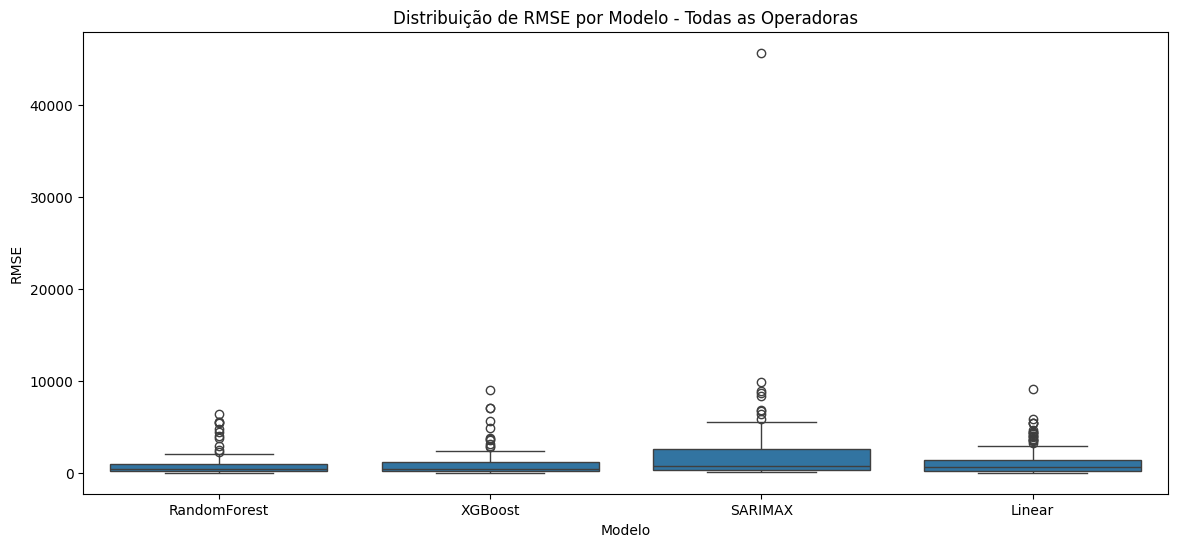

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_comp, x='Modelo', y='RMSE')
plt.title('Distribuição de RMSE por Modelo - Todas as Operadoras')

In [51]:
df_comp.to_csv("D:/Renan/Documents/Mestrado/Inteligencia artificial/Artigo/churn_analyser/data/final2.csv", index=False, encoding='utf-8')

Alvo da regressão

In [41]:
# y = df_final['QT_PORTABILIDADE_EFETIVADA']

Remover colunas que não queremos usar como input

In [42]:
# X = df_final.drop(['QT_PORTABILIDADE_EFETIVADA', 'AM_EFETIVACAO'], axis=1)

Dividir dados em treino e teste (80% / 20%)

In [43]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [44]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_pred_lr = lr.predict(X_test)

# Avaliação
# mae_lr = mean_absolute_error(y_test, y_pred_lr)
# rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
# r2_lr = r2_score(y_test, y_pred_lr)

# print(f"Linear Regression:\nMAE = {mae_lr:.2f}, RMSE = {rmse_lr:.2f}, R² = {r2_lr:.2f}")

# Random Forest Regressor

In [45]:
# rf = RandomForestRegressor(random_state=42)
# rf.fit(X_train, y_train)
# y_pred_rf = rf.predict(X_test)

# mae_rf = mean_absolute_error(y_test, y_pred_rf)
# rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# # r2_rf = r2_score(y_test, y_pred_rf)

# print(f"Random Forest:\nMAE = {mae_rf:.2f}, RMSE = {rmse_rf:.2f}, R² = {r2_rf:.2f}")


# XGBoost Regressor

In [46]:
# xgb = XGBRegressor(random_state=42)
# xgb.fit(X_train, y_train)
# y_pred_xgb = xgb.predict(X_test)

# mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
# rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
# r2_xgb = r2_score(y_test, y_pred_xgb)

# print(f"XGBoost:\nMAE = {mae_xgb:.2f}, RMSE = {rmse_xgb:.2f}, R² = {r2_xgb:.2f}")


# Resultados

In [47]:
# resultado_modelos = pd.DataFrame({
#     'Modelo': ['Linear Regression', 'Random Forest', 'XGBoost'],
#     'MAE': [mae_lr, mae_rf, mae_xgb],
#     'RMSE': [rmse_lr, rmse_rf, rmse_xgb],
#     'R2': [r2_lr, r2_rf, r2_xgb]
# })

# print(resultado_modelos)

# SARIMAX

In [48]:
#Garantir tipo datetime
# df_final['AM_EFETIVACAO'] = pd.to_datetime(df_final['AM_EFETIVACAO'])

In [49]:
#  Lista de operadoras
# operadoras = df_final['NO_PRESTADORA_DOADORA'].unique()

In [50]:
# resultados = []

# for op in operadoras:  
#     try:
        # Filtrar dados da operadora
#         df_op = df_final[df_final['NO_PRESTADORA_DOADORA'] == op].copy()
#         df_op.set_index('AM_EFETIVACAO', inplace=True)
#         df_op.sort_index(inplace=True)

        # Variável alvo e exógenas
#         y = df_op['QT_PORTABILIDADE_EFETIVADA']
#         exog = df_op[['QF', 'QIC', 'QCR', 'QAT', 'QAD', 'QAP', 'ISG']].copy()
#         exog.fillna(exog.mean(), inplace=True)  # Garantir que não haja nulos

        # Treinar SARIMAX
#         model = SARIMAX(y, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False, enforce_invertibility=False)
#         results = model.fit(disp=False)

        # Previsão in-sample
#         y_pred = results.predict(start=0, end=len(y)-1, exog=exog)

        # Erro
#         rmse = np.sqrt(mean_squared_error(y, y_pred))
#         resultados.append({'Operadora': op, 'RMSE': rmse, 'N_Meses': len(y)})

#     except Exception as e:
#         print(f"Erro ao processar {op}: {e}")


IndentationError: unexpected indent (3559364089.py, line 17)

In [ ]:
# df_resultados = pd.DataFrame(resultados).sort_values(by='RMSE')
# print(df_resultados)


In [ ]:
df_final.head()

# Resultados todos